In [1]:
!pip install torch torchvision torchaudio
!pip install torch-geometric scipy numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import numpy as np

# Example: 50 cities in 2D space
n = 50
coords = np.random.rand(n, 2)


In [3]:
from scipy.spatial.distance import cdist

D = cdist(coords, coords, metric='euclidean')
tau = 0.1  # temperature
W = np.exp(-D / tau)


In [4]:
import torch
from torch_geometric.data import Data

# Convert to PyTorch tensors
x = torch.tensor(coords, dtype=torch.float)  # node features
edge_index = torch.combinations(torch.arange(n), r=2).T
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # make bidirectional


In [5]:
edge_weights = torch.tensor(W[np.triu_indices(n, k=1)], dtype=torch.float)
edge_weights = torch.cat([edge_weights, edge_weights])  # symmetrical


In [6]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x @ x.T  # Score matrix S ∈ ℝⁿˣⁿ


In [7]:
def get_soft_indicator_matrix(S):
    T = torch.softmax(S, dim=0)  # column-wise softmax
    return T


In [8]:
def build_heat_map(T):
    n = T.shape[0]
    H = sum(T[:, [i]] @ T[:, [(i + 1) % n]].T for i in range(n))
    return H


In [9]:
def tsp_loss(T, H, D, λ1=1.0, λ2=1.0):
    row_constraint = ((T.sum(dim=1) - 1) ** 2).sum()
    no_self_loops = torch.diag(H).sum()
    distance_term = (torch.tensor(D, dtype=torch.float) * H).sum()
    return λ1 * row_constraint + λ2 * no_self_loops + distance_term


In [10]:
model = SimpleGNN(in_channels=2, hidden_channels=64, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    S = model(x, edge_index)
    T = get_soft_indicator_matrix(S)
    H = build_heat_map(T)
    loss = tsp_loss(T, H, D)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 27.8124
Epoch 10 - Loss: 27.8124
Epoch 20 - Loss: 27.8124
Epoch 30 - Loss: 27.8124
Epoch 40 - Loss: 27.8124
Epoch 50 - Loss: 27.8124
Epoch 60 - Loss: 27.8124
Epoch 70 - Loss: 27.8124
Epoch 80 - Loss: 27.8124
Epoch 90 - Loss: 27.8124
Epoch 100 - Loss: 27.8124
Epoch 110 - Loss: 27.8124
Epoch 120 - Loss: 27.8124
Epoch 130 - Loss: 27.8124
Epoch 140 - Loss: 27.8124
Epoch 150 - Loss: 27.8124
Epoch 160 - Loss: 27.8124
Epoch 170 - Loss: 27.8124
Epoch 180 - Loss: 27.8124
Epoch 190 - Loss: 27.8124


In [11]:
# Simple pruning
H_np = H.detach().numpy()
pruned_edges = (H_np > np.percentile(H_np, 95)).astype(int)


Initial Tour Length: 28.130256610242714
Optimized Tour Length: 5.716533374576133


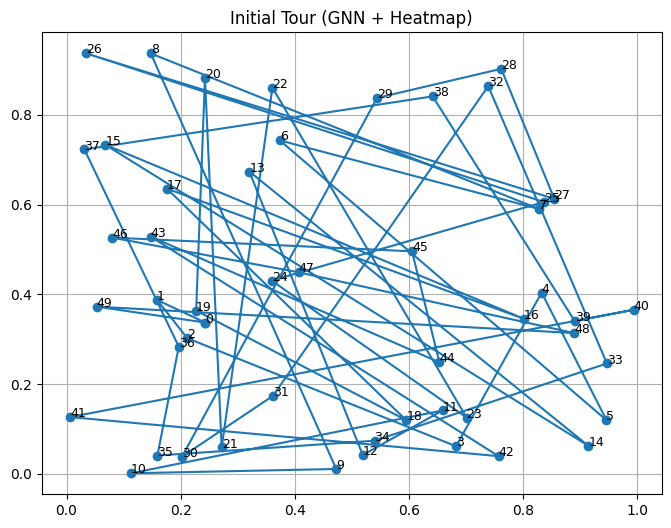

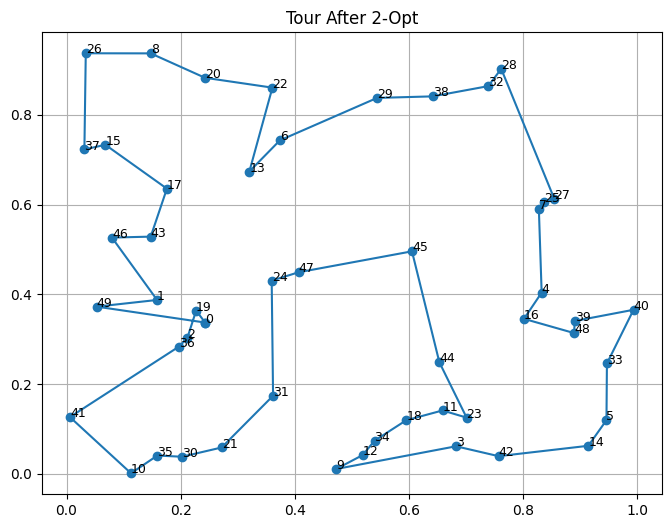

In [12]:
import matplotlib.pyplot as plt

# Step 1: Build a tour from the heat map
def build_tour_from_heatmap(H):
    H_np = H.detach().numpy()
    n = H_np.shape[0]
    visited = [False] * n
    tour = []
    current = 0
    while len(tour) < n:
        tour.append(current)
        visited[current] = True
        probs = H_np[current].copy()
        probs[tour] = -np.inf  # Mask visited
        next_city = np.argmax(probs)
        current = next_city
    return tour

# Step 2: Calculate tour length
def tour_length(tour, coords):
    return sum(np.linalg.norm(coords[tour[i]] - coords[tour[(i + 1) % len(tour)]])
               for i in range(len(tour)))

# Step 3: 2-opt swap
def two_opt(tour, coords):
    best = tour.copy()
    improved = True
    while improved:
        improved = False
        for i in range(1, len(tour) - 2):
            for j in range(i + 1, len(tour)):
                if j - i == 1: continue
                new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
                if tour_length(new_tour, coords) < tour_length(best, coords):
                    best = new_tour
                    improved = True
        tour = best
    return best

# Step 4: Run everything
initial_tour = build_tour_from_heatmap(H)
print("Initial Tour Length:", tour_length(initial_tour, coords))

optimized_tour = two_opt(initial_tour, coords)
print("Optimized Tour Length:", tour_length(optimized_tour, coords))

# Step 5: Plot
def plot_tour(tour, coords, title="TSP Tour"):
    plt.figure(figsize=(8, 6))
    ordered_coords = coords[tour + [tour[0]]]
    plt.plot(ordered_coords[:, 0], ordered_coords[:, 1], 'o-', markersize=6)
    plt.title(title)
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, str(i), fontsize=9)
    plt.grid()
    plt.show()

plot_tour(initial_tour, coords, title="Initial Tour (GNN + Heatmap)")
plot_tour(optimized_tour, coords, title="Tour After 2-Opt")
